In [1]:
from convnext_scaling.models.regnet import RegNet, BlockParams
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import List, Optional, Any, Tuple, Callable
import math
from tqdm import tqdm, trange
from torch import Tensor
from fractions import Fraction
from random import choice

import optuna
from optuna.visualization.matplotlib import plot_slice, plot_rank

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def count_params(model):
    return sum([x.numel() for x in model.parameters() if x.requires_grad])

sns.set_style("whitegrid")

/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Width propagation

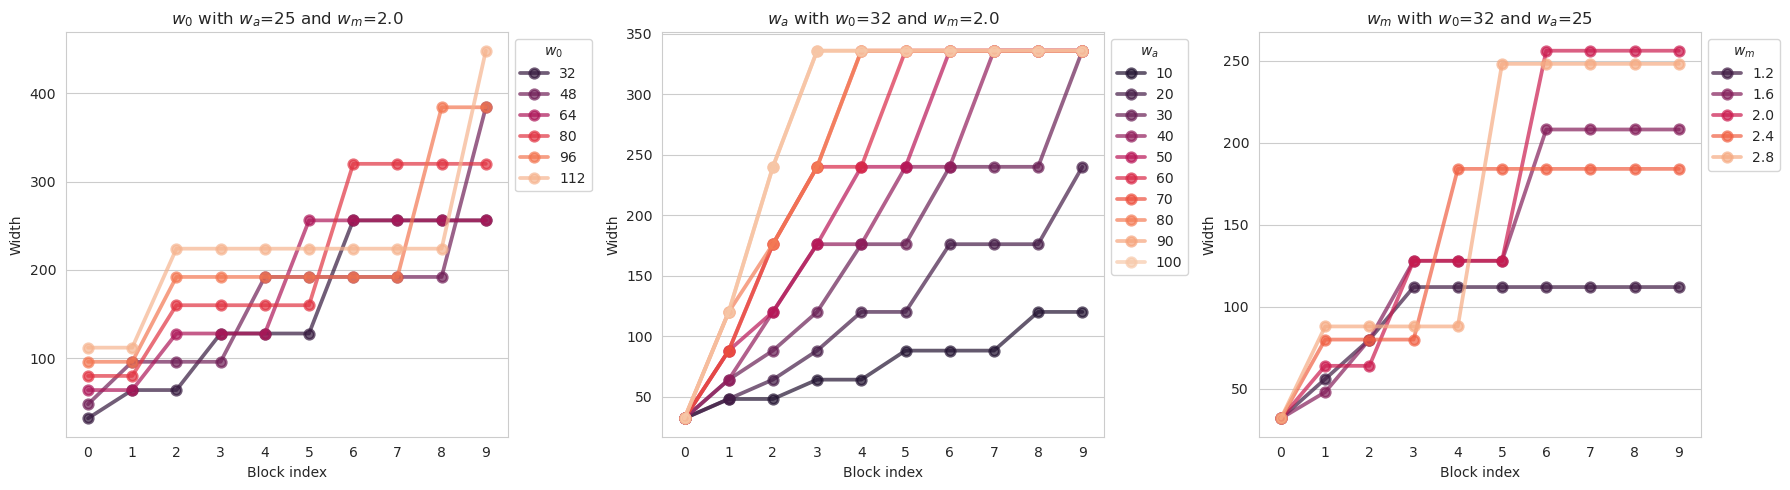

In [2]:
def get_width_sequence(block_params: BlockParams) -> List[int]:
    """Converts stage widths and depths into a sequence of block-wise widths."""
    width_sequence = []
    for width, depth in zip(block_params.widths, block_params.depths):
        width_sequence.extend([width] * depth)
    return width_sequence

# Create a figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

depth = 10

# 1st plot: Varying w_0
w_0s = [round(x, 1) for x in np.arange(32, 128, 16)]
colors = sns.color_palette("rocket", len(w_0s))
for i, w_0 in enumerate(w_0s):
    params = BlockParams.from_init_params(depth=depth, w_0=w_0, w_a=25, w_m=2.0, group_width=1, input_resolution=1024)
    widths = get_width_sequence(params)
    sns.pointplot(x=np.arange(len(widths)), y=widths, ax=axes[0], label=w_0, alpha=0.7, color=colors[i])

axes[0].set_xlabel("Block index")
axes[0].set_ylabel("Width")
axes[0].legend(title="$w_0$", loc="upper left", bbox_to_anchor=(1, 1))
axes[0].set_title("$w_0$ with $w_a$=25 and $w_m$=2.0")

# 2nd plot: Varying w_a
w_as = [round(x, 1) for x in np.arange(10, 110, 10)]
colors = sns.color_palette("rocket", len(w_as))

for i, w_a in enumerate(w_as):
    params = BlockParams.from_init_params(depth=depth, w_0=32, w_a=w_a, w_m=1.4, group_width=1, input_resolution=1024, bottleneck_multiplier=2.0)
    widths = get_width_sequence(params)
    sns.pointplot(x=np.arange(len(widths)), y=widths, ax=axes[1], label=w_a, alpha=0.7, color=colors[i])

axes[1].set_xlabel("Block index")
axes[1].set_ylabel("Width")
axes[1].legend(title="$w_a$", loc="upper left", bbox_to_anchor=(1, 1))
axes[1].set_title("$w_a$ with $w_0$=32 and $w_m$=2.0")


# 3rd plot: Varying w_m
w_ms = [round(x, 1) for x in np.arange(1.2, 3.0, 0.4)]
colors = sns.color_palette("rocket", len(w_ms))

for i, w_m in enumerate(w_ms):
    params = BlockParams.from_init_params(depth=depth, w_0=32, w_a=25, w_m=w_m, group_width=1, input_resolution=1024)
    widths = get_width_sequence(params)
    sns.pointplot(x=np.arange(len(widths)), y=widths, ax=axes[2], label=w_m, alpha=0.7, color=colors[i])

axes[2].set_xlabel("Block index")
axes[2].set_ylabel("Width")
axes[2].legend(title="$w_m$", loc="upper left", bbox_to_anchor=(1, 1))
axes[2].set_title("$w_m$ with $w_0$=32 and $w_a$=25")


plt.tight_layout()
plt.savefig("./plots/width_progression.png", dpi=280)
plt.show()


# Design space

In [22]:
def doubling_space(start, end):
    """Generate an array of values that doubles from start to end (inclusive)."""
    assert 0 < start and 0 < end and start < end
    times_to_double = math.log2(end / start) + 1
    return start * 2 ** np.arange(times_to_double)

def suggest_param_grid(trial):

    init_lr = trial.suggest_float("init_lr", 1e-4, 1e-2, log=True)
    init_kernel_size = trial.suggest_categorical("init_kernel_size", [3, 9, 15])

    w_init = trial.suggest_int("w_init", 32, 64, step=8)
    w_0 = trial.suggest_int("w_0", 32, 128, step=8)
    w_0 = max(w_0, w_init)

    w_m = trial.suggest_float("w_m", 1.1, 3.0, step=0.1)
    w_a = trial.suggest_int("w_a", 10, 50)
    depth = trial.suggest_int("depth", 4, 20)

    # group_width: ensure_divisible_by=4 and allow_ones=True
    group_width = trial.suggest_categorical(
        "group_width", doubling_space(1, 32).astype(int).tolist()
    )

    bottleneck_multiplier = trial.suggest_categorical(
        "bottleneck_multiplier", doubling_space(0.5, 4.0).tolist()
    )

    se_ratio = trial.suggest_categorical("se_ratio", [0.25, None])

    return {
        "w_init": w_init,
        "init_lr": init_lr,
        "init_kernel_size": init_kernel_size,
        "depth": depth,
        "w_0": w_0,
        "w_a": w_a,
        "w_m": round(w_m, 1),
        "group_width": group_width,
        "bottleneck_multiplier": round(bottleneck_multiplier, 1),
        "se_ratio": se_ratio,
    }


study = optuna.create_study()
res = []
for _ in trange(500):
    trial = study.ask()
    hyper_params = suggest_param_grid(trial)
    p = BlockParams.from_init_params(**hyper_params)
    model = RegNet(p, stem_width=hyper_params["w_init"])
    nparams = count_params(model)
    hyper_params["params"] = nparams
    hyper_params["nstages"] = len(p.depths)
    res.append(hyper_params)
df = pd.DataFrame(res)
df.se_ratio = df.se_ratio.fillna(0)

[I 2025-02-04 11:44:39,895] A new study created in memory with name: no-name-57a4b0ff-b87b-4c39-b05e-6f72d83d443b
100%|██████████| 500/500 [00:26<00:00, 19.09it/s]


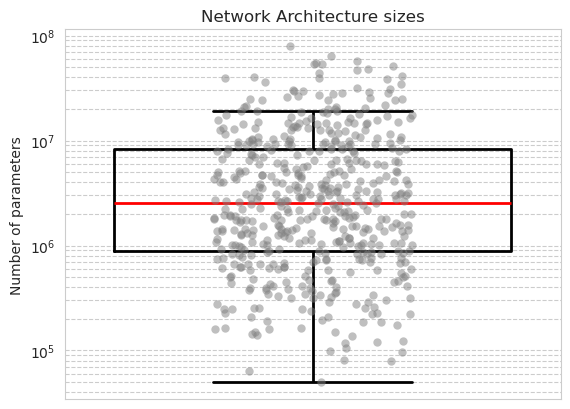

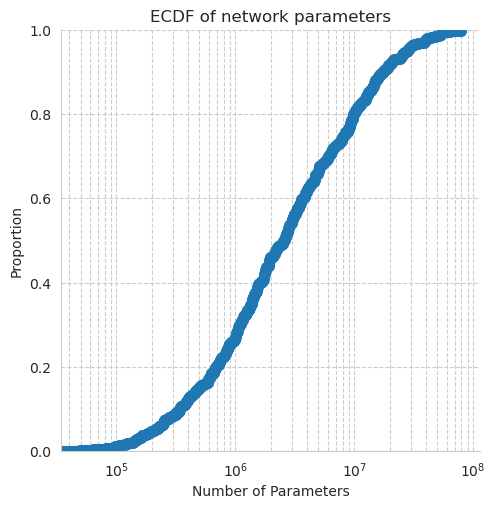

In [23]:
plt.title("Network Architecture sizes")
sns.boxplot(y=df.params, width=0.8, fill=False, color="black", fliersize=0, medianprops=dict(color="red", lw=2), linewidth=2)
sns.stripplot(y=df.params, size=6, jitter=0.2, color="gray", alpha=0.5)
plt.yscale("log")
plt.ylabel("Number of parameters")
plt.grid(which="both", axis="y", ls="--")
plt.savefig("./plots/net_arch_sizes.png", dpi=280)
plt.show()

sns.displot(x=df.params, kind="ecdf", lw=8)
plt.title("ECDF of network parameters")
plt.xlabel("Number of Parameters")
plt.xscale("log")
plt.grid(which="both", axis="both", ls="--")
plt.savefig("./plots/net_arch_sizes_ecdf.png", dpi=280)
plt.show()

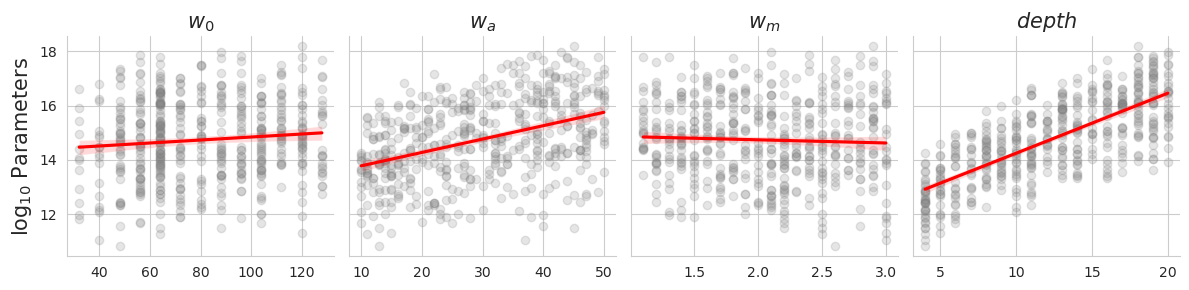

In [24]:
_df = df[["w_0", "w_a", "w_m", "depth", "params"]].copy()
_df.params = np.log(_df.params)

axs = sns.lmplot(_df.melt(id_vars="params"), x="value", y="params", col="variable",
                 facet_kws=dict(sharex=False, sharey=True),
                 scatter_kws=dict(alpha=0.2, color="gray"),
                 line_kws=dict(color="red"),
                 col_wrap=4, height=3)
axs.set_titles(col_template="${col_name}$", size=15)
axs.set_ylabels("log$_{10}$ Parameters", fontsize=15)
axs.set_xlabels("")
plt.tight_layout()
plt.savefig("./plots/hyperparameter_params_correlation.png", dpi=280)

plt.show()

# Preperation of ResNet scaling

In this notebook:  
1. Introduce and test ScalableResNet
2. Define parameter grid for scaling
3. Compute FLOPS and number of paramters for models in parameter grid

In [243]:
import torch
from torch.utils.flop_counter import FlopCounterMode

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from convnext_scaling.models.resnet import ResNet, BasicBlock, Bottleneck, ScalableResNet
from convnext_scaling.models.convnext import ConvNeXt, CNBlockConfig

from convnext_scaling.models.model_factory import MODELS


sns.set_style("whitegrid")

def count_params(model):
    return sum([x.numel() for x in model.parameters() if x.requires_grad])

def count_layers(model):
    return sum([1 for x in model.parameters() if x.requires_grad])

@torch.no_grad()
def get_flops(model):
    with FlopCounterMode(display=False, depth=None) as flop_counter:
        model(torch.rand(1, 12, 1024))
    return flop_counter.get_total_flops()

In [244]:
def get_layer_depth(depth):
    """Resnet specific function to allocate the layer depth to the 4 blocks of ResNet."""
    blocks = [1, 1, 1, 1]  # 4 blocks in ResNet with one layer each
    for i in range(depth):

        # Logic is inspired by PyTorch implementation of ResNet18-ResNet101
        if i < 8:
            index = i % 4
        else:
            index = 2

        blocks[index] += 1  # Increase number of layers for the block at index
    return blocks


def scale_convnext(depth, width):
    settings = []
    _width = width
    for i, d in enumerate(get_layer_depth(depth)):
        c = CNBlockConfig(_width, _width * 2, d)
        settings.append(c)
        _width *= 2
    return ConvNeXt(settings)

def scale_basic_resnet(depth, width):
    layers = get_layer_depth(depth)
    return ResNet(BasicBlock, layers, width)

In [245]:
# resolutions = [1024, 2048, 4096, 8192]
def generate_scaling_param_grid(model_scale_generator, depth_range=range(0, 30, 4), start_width=16, width_incriment=16, max_params=40e6):
    param_grid = []
    width = start_width
    
    for depth in tqdm(list(depth_range)):
        model = model_scale_generator(depth=depth, width=width)
        params = count_params(model)
        flops = get_flops(model)

        while params < max_params:
            try:
                sd = round(model.model.layer4[-1].stochastic_depth.p, 5)
            except:
                sd = None
    
            try:
                block_name = model.model.layer4[0].__class__.__name__
            except:
                block_name = None

            param_grid.append({
                "width": width,
                "depth": depth,
                "params": params,
                "flops": flops,
                "sd": sd,
                "block": block_name
            })
    
            width += width_incriment

            model = model_scale_generator(depth=depth, width=width)
            params = count_params(model)
            flops = get_flops(model)
        
        del model
        width = start_width

    param_grid = pd.DataFrame(param_grid)
    param_grid["mparams"] = param_grid.params / 10**6
    param_grid["gflops"] = param_grid.flops / 10**9
    param_grid["depth"] = param_grid["depth"].astype("category")
    param_grid["width"] = param_grid["width"].astype("category")
    
    return param_grid

In [246]:
resnet_param_grid = generate_scaling_param_grid(scale_basic_resnet, start_width=32, width_incriment=32, max_params=40e6)

100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


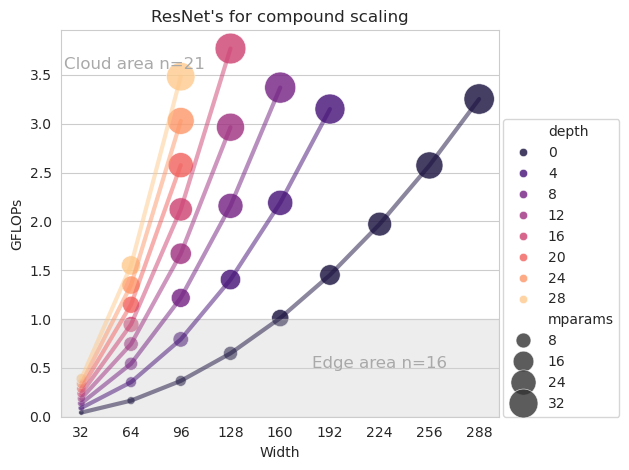

In [250]:
sns.scatterplot(resnet_param_grid, x="width", y="gflops", hue="depth", size="mparams", palette="magma", sizes=(15, 500), alpha=0.8)
sns.lineplot(resnet_param_grid, x="width", y="gflops", hue="depth", palette="magma", alpha=0.5, legend=False, lw=3)

plt.title("ResNet's for compound scaling")
plt.ylabel("GFLOPs")
plt.xlabel("Width")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.ylim(0, ymax)

# Shade areas
plt.axhspan(0, 1, color='lightgray', alpha=0.4)

# Add text annotation for the shaded area
plt.text(xmax * 0.6, 0.5, f"Edge area n={(resnet_param_grid.gflops <= 1).sum()}", color='darkgray', fontsize=12)
plt.text(xmin * 1.1, ymax * 0.9, f"Cloud area n={(resnet_param_grid.gflops > 1).sum()}", color='darkgray', fontsize=12)

plt.xticks(resnet_param_grid.width.unique(), resnet_param_grid.width.unique())

plt.grid(axis="x")
plt.legend(loc=(1.01, 0))
plt.tight_layout()
plt.savefig("./plots/scaling_resnet_basic.png", dpi=280)

In [256]:
convnext_param_grid = generate_scaling_param_grid(scale_convnext, start_width=32, width_incriment=32, max_params=40e6)

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


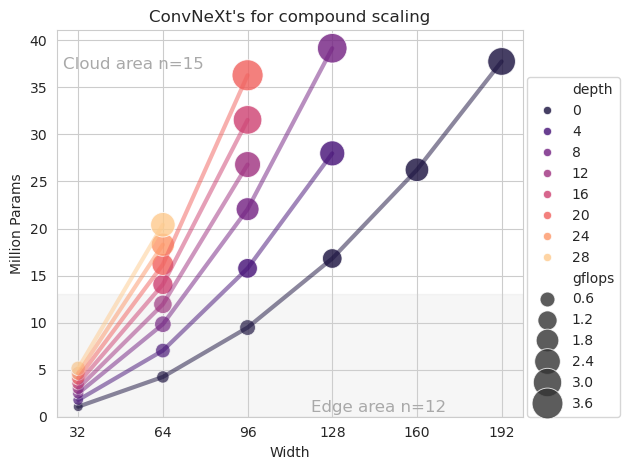

In [274]:
scatterplot = sns.scatterplot(convnext_param_grid, x="width", y="mparams", hue="depth", size="gflops", palette="magma", sizes=(50, 500), alpha=0.8)
sns.lineplot(convnext_param_grid, x="width", y="mparams", hue="depth", palette="magma", alpha=0.5, legend=False, lw=3)

plt.title("ConvNeXt's for compound scaling")
plt.ylabel("Million Params")
plt.xlabel("Width")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.ylim(0, ymax)

# Shade areas
plt.axhspan(0, 13, color='lightgray', alpha=0.2)

# Add text annotation for the shaded area
plt.text(xmax * 0.6, 0.5, f"Edge area n={(convnext_param_grid.gflops <= 1).sum()}", color='darkgray', fontsize=12)
plt.text(xmin * 1.1, ymax * 0.9, f"Cloud area n={(convnext_param_grid.gflops > 1).sum()}", color='darkgray', fontsize=12)

plt.xticks(convnext_param_grid.width.unique(), convnext_param_grid.width.unique())

plt.legend(loc=(1.01, 0))

plt.tight_layout()
plt.show()

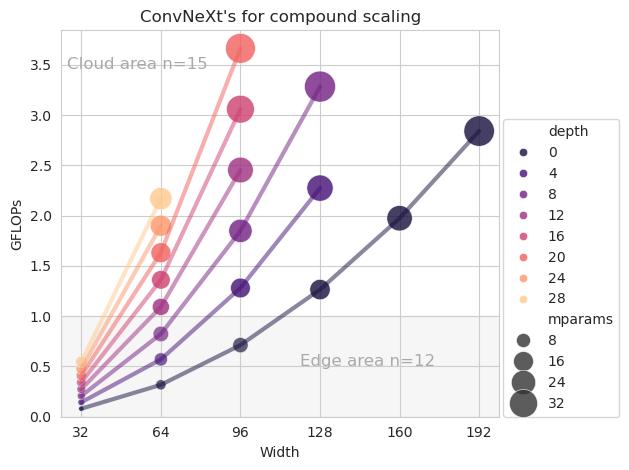

In [257]:
scatterplot = sns.scatterplot(convnext_param_grid, x="width", y="gflops", hue="depth", size="mparams", palette="magma", sizes=(15, 500), alpha=0.8)
sns.lineplot(convnext_param_grid, x="width", y="gflops", hue="depth", palette="magma", alpha=0.5, legend=False, lw=3)

plt.title("ConvNeXt's for compound scaling")
plt.ylabel("GFLOPs")
plt.xlabel("Width")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.ylim(0, ymax)

# Shade areas
plt.axhspan(0, 1, color='lightgray', alpha=0.2)

# Add text annotation for the shaded area
plt.text(xmax * 0.6, 0.5, f"Edge area n={(convnext_param_grid.gflops <= 1).sum()}", color='darkgray', fontsize=12)
plt.text(xmin * 1.1, ymax * 0.9, f"Cloud area n={(convnext_param_grid.gflops > 1).sum()}", color='darkgray', fontsize=12)

plt.xticks(convnext_param_grid.width.unique(), convnext_param_grid.width.unique())

plt.legend(loc=(1.01, 0))

plt.tight_layout()
plt.show()

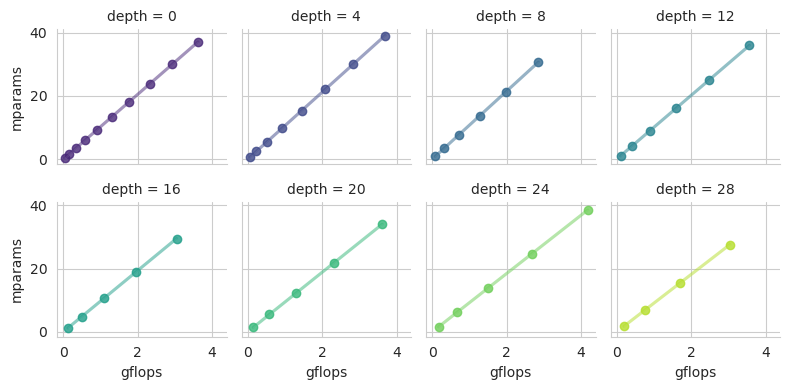

In [182]:
param_grid.depth = param_grid.depth.astype(int)
sns.lmplot(param_grid, x="gflops", y="mparams", hue="depth", col="depth", col_wrap=4, line_kws=dict(alpha=0.5), palette="viridis", height=2)